In [7]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'PSN' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

max_ = traindf.Return.max()
min_ = traindf.Return.min()
# traindf = (traindf - min_) / (max_ - min_)
# validdf = (validdf - min_) / (max_ - min_)
# testdf = (testdf - min_) / (max_ - min_)

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            200,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)


### Training

In [67]:
model.train(trainloader, validloader)

[00:00] Epoch 1/200 - Train Loss : 1.004240 / Val Loss : 1.011569
[00:03] Epoch 10/200 - Train Loss : 0.978700 / Val Loss : 1.016536
[00:07] Epoch 20/200 - Train Loss : 0.972567 / Val Loss : 1.021205
[00:10] Epoch 30/200 - Train Loss : 0.969949 / Val Loss : 1.022521
[00:14] Epoch 40/200 - Train Loss : 0.967625 / Val Loss : 1.023280
[00:18] Epoch 50/200 - Train Loss : 0.964915 / Val Loss : 1.024182
[00:21] Epoch 60/200 - Train Loss : 0.961534 / Val Loss : 1.025119
[00:25] Epoch 70/200 - Train Loss : 0.957221 / Val Loss : 1.025817
[00:29] Epoch 80/200 - Train Loss : 0.951696 / Val Loss : 1.026036
[00:33] Epoch 90/200 - Train Loss : 0.944706 / Val Loss : 1.025725
[00:37] Epoch 100/200 - Train Loss : 0.936104 / Val Loss : 1.025166
[00:40] Epoch 110/200 - Train Loss : 0.925962 / Val Loss : 1.024961
[00:44] Epoch 120/200 - Train Loss : 0.914641 / Val Loss : 1.025792
[00:48] Epoch 130/200 - Train Loss : 0.902697 / Val Loss : 1.028120
[00:52] Epoch 140/200 - Train Loss : 0.890673 / Val Loss : 

### Evaluation

In [57]:
model.evaluate(testloader)

Test MAE : 0.855519 | Test MAPE  : 16.328028 | Test RSME : 1.311961 | Test Theil-U 0.712446


RMSE : 1.1146601455872613
MAE : 0.8005597006268088
MAPE : 2.7542779516293856
TheilU : 0.8029203396526763


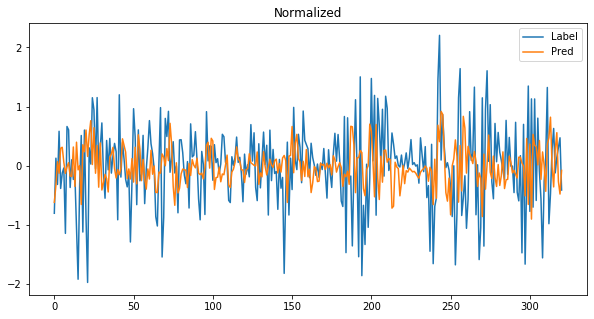

RMSE : 5.887671937673436e-05
MAE : 0.005818275602334458
MAPE : 2598937.3344319332
TheilU : 0.8012185210142357


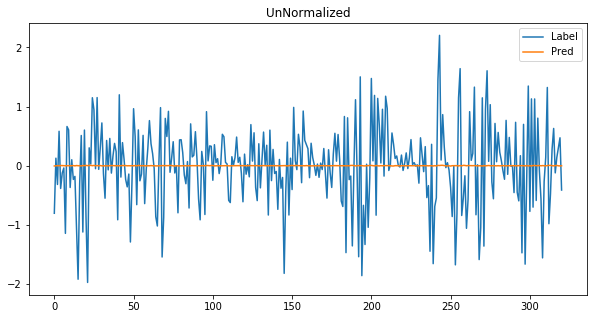

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import torch

preds, targets = [], []
model.model.eval()
with torch.no_grad():
    for features, target in testloader:
        outputs = model.model(features)
        preds += outputs.numpy().T.tolist()[0]
        targets += target.numpy().tolist()

preds = np.array(preds)
targets = np.array(targets)

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.title("Normalized")
plt.legend()
plt.show();

preds = np.array(preds)*testsigma + testmu
targets = np.array(targets)*testsigma + testmu

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.title("UnNormalized")
plt.legend();

## Train and Evaluate All Models

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.510062 / Val Loss : 0.532882
[00:37] Epoch 100/500 - Train Loss : 1.331024 / Val Loss : 0.550322
[01:13] Epoch 200/500 - Train Loss : 1.259007 / Val Loss : 0.567780
[01:48] Epoch 300/500 - Train Loss : 1.236537 / Val Loss : 0.587703
[02:24] Epoch 400/500 - Train Loss : 1.206248 / Val Loss : 0.611480
[03:00] Epoch 500/500 - Train Loss : 1.189514 / Val Loss : 0.643403
Train MAE : 0.7809 | Train MAPE  : 4.2121 | Train RSME : 1.1587 | Train Theil-U 0.5959
Valid MAE : 0.6421 | Valid MAPE  : 2.0375 | Valid RSME : 0.6434 | Valid Theil-U 0.7593
Test MAE : 0.006119 | Test MAPE  : 13.083130 | Test RSME : 0.000066 | Test Theil-U 0.771451


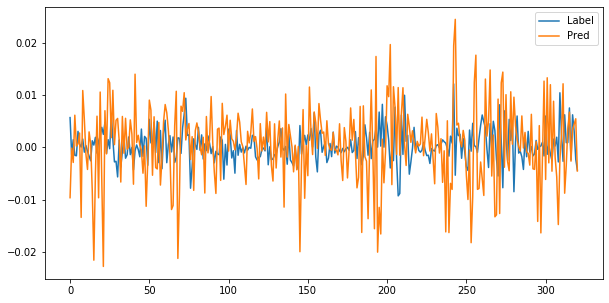




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.546425 / Val Loss : 0.533365
[00:52] Epoch 100/500 - Train Loss : 1.132374 / Val Loss : 0.783180
[01:44] Epoch 200/500 - Train Loss : 1.041571 / Val Loss : 0.887454
[02:36] Epoch 300/500 - Train Loss : 1.026241 / Val Loss : 0.912126
[03:27] Epoch 400/500 - Train Loss : 1.015458 / Val Loss : 0.938964
[04:20] Epoch 500/500 - Train Loss : 1.007853 / Val Loss : 0.959998
Train MAE : 0.7385 | Train MAPE  : 6.1293 | Train RSME : 0.9447 | Train Theil-U 0.5006
Valid MAE : 0.7474 | Valid MAPE  : 2.9834 | Valid RSME : 0.9600 | Valid Theil-U 0.7343
Test MAE : 0.006904 | Test MAPE  : 12.888106 | Test RSME : 0.000082 | Test Theil-U 0.692489


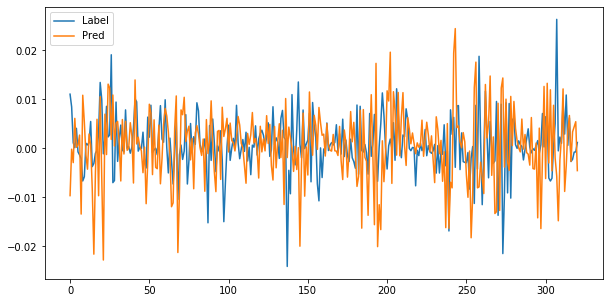




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.019915 / Val Loss : 0.005379
[00:35] Epoch 100/500 - Train Loss : 0.012821 / Val Loss : 0.007520
[01:10] Epoch 200/500 - Train Loss : 0.012622 / Val Loss : 0.007610
[01:44] Epoch 300/500 - Train Loss : 0.012698 / Val Loss : 0.008045
[02:19] Epoch 400/500 - Train Loss : 0.012680 / Val Loss : 0.009231
[02:54] Epoch 500/500 - Train Loss : 0.013160 / Val Loss : 0.008688
Train MAE : 0.0918 | Train MAPE  : 522.7152 | Train RSME : 0.0134 | Train Theil-U 0.0988
Valid MAE : 0.0792 | Valid MAPE  : 0.1279 | Valid RSME : 0.0087 | Valid Theil-U 0.0806
Test MAE : 0.008923 | Test MAPE  : 2.914911 | Test RSME : 0.000112 | Test Theil-U 0.710257


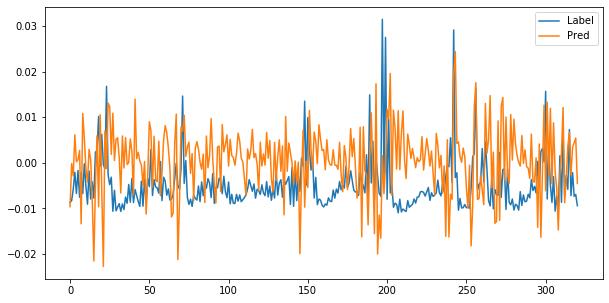




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.513964 / Val Loss : 0.528553
[00:36] Epoch 100/500 - Train Loss : 1.295820 / Val Loss : 0.547118
[01:12] Epoch 200/500 - Train Loss : 1.043627 / Val Loss : 0.629663
[01:47] Epoch 300/500 - Train Loss : 0.972575 / Val Loss : 0.687260
[02:23] Epoch 400/500 - Train Loss : 0.944485 / Val Loss : 0.694593
[02:58] Epoch 500/500 - Train Loss : 0.930572 / Val Loss : 0.693518
Train MAE : 0.7124 | Train MAPE  : 2.1544 | Train RSME : 0.8930 | Train Theil-U 0.4955
Valid MAE : 0.6419 | Valid MAPE  : 2.2643 | Valid RSME : 0.6935 | Valid Theil-U 0.7163
Test MAE : 0.006234 | Test MAPE  : 6.888390 | Test RSME : 0.000071 | Test Theil-U 0.694990


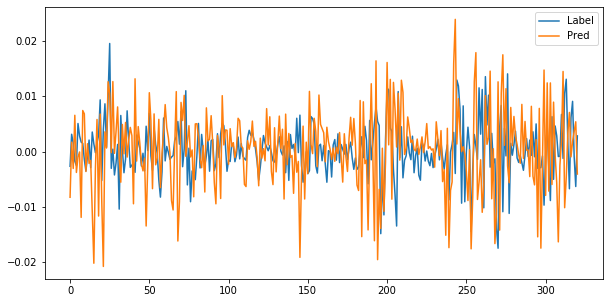




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.497778 / Val Loss : 0.543041
[00:51] Epoch 100/500 - Train Loss : 1.179359 / Val Loss : 0.742008
[01:42] Epoch 200/500 - Train Loss : 1.125757 / Val Loss : 0.783600
[02:34] Epoch 300/500 - Train Loss : 1.107042 / Val Loss : 0.799142
[03:31] Epoch 400/500 - Train Loss : 1.100926 / Val Loss : 0.808491
[04:30] Epoch 500/500 - Train Loss : 1.097702 / Val Loss : 0.812786
Train MAE : 0.7659 | Train MAPE  : 2.6175 | Train RSME : 1.0477 | Train Theil-U 0.5537
Valid MAE : 0.6944 | Valid MAPE  : 3.4693 | Valid RSME : 0.8128 | Valid Theil-U 0.7019
Test MAE : 0.006860 | Test MAPE  : 5.645072 | Test RSME : 0.000076 | Test Theil-U 0.696642


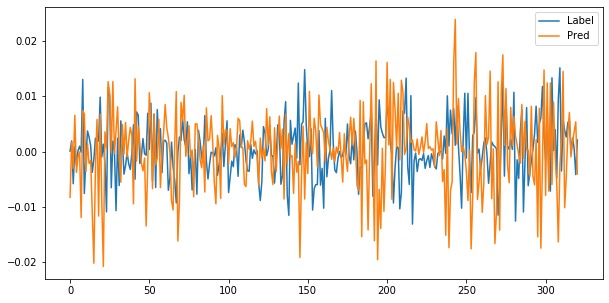




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.020688 / Val Loss : 0.013853
[00:39] Epoch 100/500 - Train Loss : 0.013806 / Val Loss : 0.007036
[01:19] Epoch 200/500 - Train Loss : 0.013804 / Val Loss : 0.007164
[01:58] Epoch 300/500 - Train Loss : 0.013596 / Val Loss : 0.007291
[02:33] Epoch 400/500 - Train Loss : 0.013569 / Val Loss : 0.007483
[03:09] Epoch 500/500 - Train Loss : 0.013002 / Val Loss : 0.008045
Train MAE : 0.0885 | Train MAPE  : 914.2021 | Train RSME : 0.0136 | Train Theil-U 0.1009
Valid MAE : 0.0739 | Valid MAPE  : 0.1228 | Valid RSME : 0.0080 | Valid Theil-U 0.0776
Test MAE : 0.007050 | Test MAPE  : 4.887167 | Test RSME : 0.000077 | Test Theil-U 0.726482


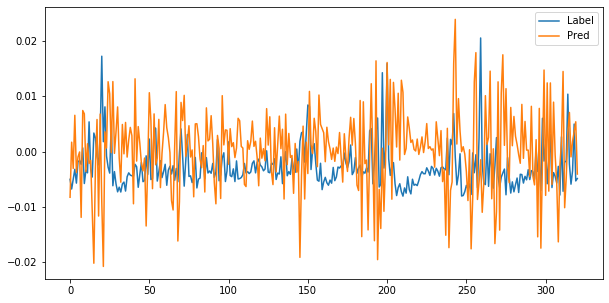




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.447529 / Val Loss : 0.548172
[00:37] Epoch 100/500 - Train Loss : 1.288793 / Val Loss : 0.566932
[01:12] Epoch 200/500 - Train Loss : 0.997047 / Val Loss : 0.693583
[01:48] Epoch 300/500 - Train Loss : 0.931850 / Val Loss : 0.772891
[02:23] Epoch 400/500 - Train Loss : 0.911513 / Val Loss : 0.821471
[02:59] Epoch 500/500 - Train Loss : 0.903775 / Val Loss : 0.838356
Train MAE : 0.7081 | Train MAPE  : 1.8799 | Train RSME : 0.8595 | Train Theil-U 0.4765
Valid MAE : 0.7008 | Valid MAPE  : 3.6970 | Valid RSME : 0.8384 | Valid Theil-U 0.6992
Test MAE : 0.008500 | Test MAPE  : 6.676655 | Test RSME : 0.000125 | Test Theil-U 0.740631


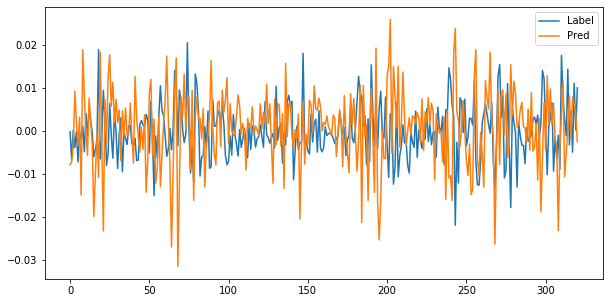




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.461822 / Val Loss : 0.540194
[00:51] Epoch 100/500 - Train Loss : 0.993470 / Val Loss : 0.747049
[01:43] Epoch 200/500 - Train Loss : 0.892574 / Val Loss : 0.848571
[02:37] Epoch 300/500 - Train Loss : 0.846386 / Val Loss : 0.901355
[03:36] Epoch 400/500 - Train Loss : 0.830741 / Val Loss : 0.951458
[04:35] Epoch 500/500 - Train Loss : 0.820168 / Val Loss : 0.972555
Train MAE : 0.6846 | Train MAPE  : 2.6288 | Train RSME : 0.7849 | Train Theil-U 0.4459
Valid MAE : 0.7649 | Valid MAPE  : 5.3440 | Valid RSME : 0.9726 | Valid Theil-U 0.6895
Test MAE : 0.008990 | Test MAPE  : 5.038039 | Test RSME : 0.000134 | Test Theil-U 0.696744


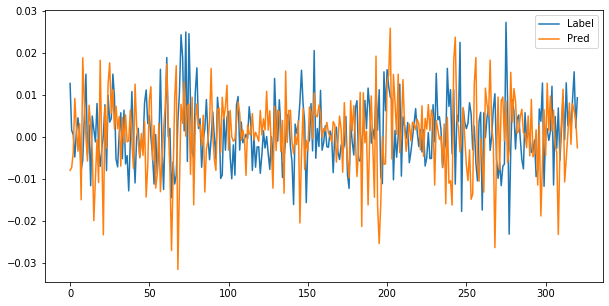




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.018491 / Val Loss : 0.011348
[00:39] Epoch 100/500 - Train Loss : 0.014424 / Val Loss : 0.005899
[01:19] Epoch 200/500 - Train Loss : 0.014176 / Val Loss : 0.006065
[01:59] Epoch 300/500 - Train Loss : 0.013912 / Val Loss : 0.006241
[02:39] Epoch 400/500 - Train Loss : 0.014141 / Val Loss : 0.006323
[03:19] Epoch 500/500 - Train Loss : 0.014119 / Val Loss : 0.006364
Train MAE : 0.0905 | Train MAPE  : 1185.9195 | Train RSME : 0.0138 | Train Theil-U 0.1035
Valid MAE : 0.0643 | Valid MAPE  : 0.1114 | Valid RSME : 0.0064 | Valid Theil-U 0.0706
Test MAE : 0.007622 | Test MAPE  : 6.867873 | Test RSME : 0.000088 | Test Theil-U 0.757482


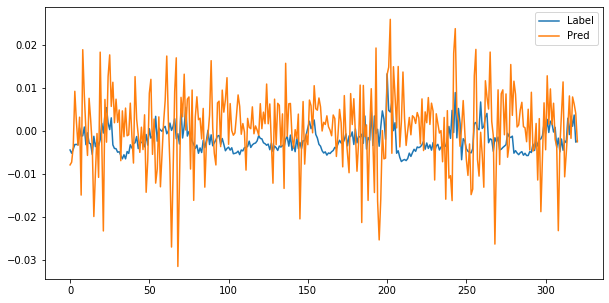

In [8]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            
            mu, sigma = np.mean(traindf.Return.tolist()+validdf.Return.tolist()+testdf.Return.tolist()), np.std(traindf.Return.tolist()+validdf.Return.tolist()+testdf.Return.tolist())

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)

        else:
            
            max_, min_ = np.max(traindf.Return.tolist()+validdf.Return.tolist()+testdf.Return.tolist()), np.min(traindf.Return.tolist()+validdf.Return.tolist()+testdf.Return.tolist())
            
            traindf = (traindf -  min_) / (max_ - min_)
            validdf = (validdf -  min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)


            
        model = NN.Model(NNtype)
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    500,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        #model.evaluate(testloader)
        
        labels, preds = model.Getevaluation(testloader)
        
        if NNtype != "PSN":
            labels = sigma * np.array(labels) + mu
            preds = sigma * np.array(preds) + mu
        else :
            labels = (max_ - min_) * np.array(labels) + min_
            preds = (max_ - min_) * np.array(preds) + min_
        
        testRMSE = mean_squared_error(labels, preds)
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RSME : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        plt.figure(figsize=(10,5))
        plt.plot(labels, label="Label")
        plt.plot(preds, label="Pred")
        plt.legend()
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [9]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [71]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005390 | Test MAPE  : 3.646229 | Test RSME : 0.000052 | Test Theil-U 0.926919


# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

# To work

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [15]:
Table4

,Statistic,MLP,RNN,PSN
ETF,,,,
SPY,MAE,0.005533,0.005745,0.005533
SPY,MAPE,1.167107,1.459932,1.501336
SPY,RMSE,0.000055,0.000060,0.000055
SPY,THEIL-U,0.925617,0.819338,0.858615
DIA,MAE,0.005420,0.005653,0.005405
DIA,MAPE,1.971646,2.648959,5.369128
DIA,RMSE,0.000053,0.000055,0.000054
DIA,THEIL-U,0.910827,0.836283,0.855665
QQQ,MAE,0.006660,0.006684,0.006594
